In [52]:
import numpy as np
from lstchain.image.muon.muon_analysis import pixel_coords_to_telescope
from ctapipe.io import EventSource
import matplotlib.pyplot as plt
from lstchain.reco import r0_to_dl1
from ctapipe.image import ImageProcessor
from ctapipe.image.muon import MuonProcessor
from ctapipe.calib import CameraCalibrator

import glob

filename = '/Users/vdk//muons2024/data/for_comparison/nsb_tuning/triple_tuning/run101_muon.simtel.gz'
source = EventSource(filename, max_events = 5000)

In [2]:
tel_description = source.subarray.tels[1]
geom = tel_description.camera.geometry
equivalent_focal_length = tel_description.optics.equivalent_focal_length
x_coord, y_coord = pixel_coords_to_telescope(geom, equivalent_focal_length)

astropy.coordinates.angles.Longitude

### How to sum up the binned intensity

In [3]:
alpha_angles = np.array([0,1,0,2,0])  # Your list of bin indices (1855 elements, ranging from 0 to 359)
image_clean = np.array([5,15,5,15,5])  # Your list of intensity values (1855 elements)

# Number of bins
num_bins = 5

# Initialize an array to hold the summed values for each bin
binned_sums = np.zeros(num_bins)

# Use np.add.at to accumulate values into the corresponding bins
np.add.at(binned_sums, alpha_angles, image_clean)
binned_sums

array([15., 15., 15.,  0.,  0.])

array([15., 15., 15.,  0.,  0.])

In [68]:
def find_alpha_angles(x, y, x_center, y_center):
    """
    It should return the array with 1855 elements, each element contain angle with respect to the muon ring
    """
    # Calculate the angle with respect to the muon ring
    alpha_angles = np.rad2deg(np.arctan2(y - y_center, x - x_center))
    alpha_angles = np.round(alpha_angles).astype(int)
    alpha_angles[alpha_angles < 0] += 360
    return np.array(alpha_angles)

def intensity_binning(x, y, x_center, y_center, image, clean_mask):
    """
    It should return the array with 360 elements, each element contain number of p.e. in the bin width 1 deg
    """
    # Its a list with angles, where to each x,y element of pixel we map the angle with respect to this particular muon ring. Each element should be rounded to integer, to serve as a bin.
    
    alpha_angles = find_alpha_angles(x, y, x_center, y_center)
    # print(f"Alpha angles shape : {alpha_angles.shape}")
    # print(f"Alpha angles : {alpha_angles}")
    intensity_azimuth = np.zeros(360)
    # print(f"Intensity azimuth shape : {intensity_azimuth.shape}")
    # print(f"Image clean shape : {image.shape}")
    print(np.max(alpha_angles))  # Check if this exceeds 359
    print(np.min(alpha_angles))  # Should be >= 0
    print(np.shape(intensity_azimuth), np.shape(alpha_angles), np.shape(image))
    print(intensity_azimuth[359])
    image[~clean_mask] = 0
    np.add.at(intensity_azimuth, alpha_angles, image)
    return intensity_azimuth


## Tests

In [16]:
filename = '/Users/vdk//muons2024/data/for_comparison/nsb_tuning/triple_tuning/run101_muon.simtel.gz'
source = EventSource(filename, max_events = 50)
event_iterator = iter(source)
events = np.array([])
for event in event_iterator:
        events = np.append(events, event)

In [17]:
event = events[0]
image_processor = ImageProcessor(source.subarray)
muon_processor = MuonProcessor(source.subarray)
calib = CameraCalibrator(image_extractor_type="GlobalPeakWindowSum",subarray = source.subarray)

calib(event)
image_processor(event)
muon_processor(event)

TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types


In [102]:
min(y_coord.degree)

-2.3976043204809088

In [109]:
test_alpha = find_alpha_angles(x_coord.degree, y_coord.degree, 0.3,0)
test_alpha

array([180, 192, 200, ..., 149, 200, 202])

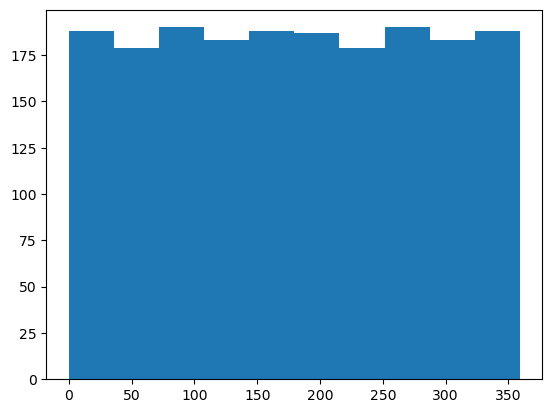

In [121]:
test_alpha = find_alpha_angles(x_coord.degree, y_coord.degree, 0,0)
z,x,c = plt.hist(test_alpha, bins = 10)

In [128]:
event.muon.tel[1].ring.center_fov_lat

<Quantity 0.39823765 deg>

In [129]:
alpha_angles = find_alpha_angles(x_coord.degree, y_coord.degree, 0, 0)
image = event.dl1.tel[1].image

# Ensure the shapes match
if alpha_angles.shape != image.shape:
    raise ValueError(f"Shape mismatch: alpha_angles shape {alpha_angles.shape} and image shape {image.shape}")

test_intensity = intensity_binning(x_coord.degree, y_coord.degree, 0.0639, 0.39, image, event.dl1.tel[1].image_mask)


359
0
(360,) (1855,) (1855,)
0.0


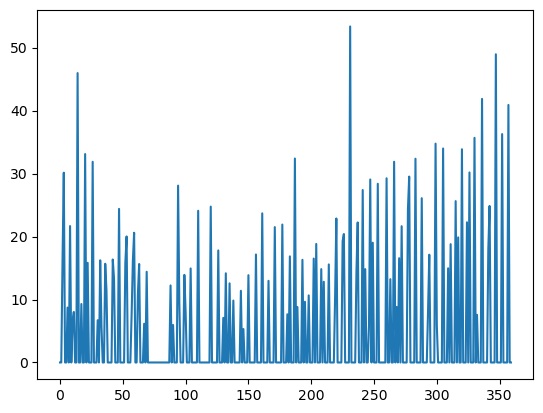

In [138]:
x_values = [i for i in range(360)]
#plt.scatter(x_values,test_intensity)
#plt.hist(test_intensity, bins = 10)
plt.plot(test_intensity)

In [137]:
test_intensity

array([ 0.        ,  0.        , 16.22218132, 30.1362381 ,  0.        ,
        0.        ,  8.71876049,  0.        , 21.66098404,  0.        ,
        6.60053682,  8.02578068,  0.        ,  0.        , 45.95645523,
        0.        ,  0.        ,  9.28253651,  0.        ,  0.        ,
       33.09766769,  0.        , 15.8245306 ,  0.        ,  0.        ,
        0.        , 31.86842155,  0.        ,  0.        ,  0.        ,
        6.70855379,  0.        , 16.22596169,  5.75111151,  0.        ,
        0.        , 15.67385578, 11.39379978,  0.        ,  0.        ,
        0.        ,  0.        , 16.35178757, 13.31658745,  0.        ,
        0.        ,  0.        , 24.38845158,  0.        ,  0.        ,
        0.        ,  0.        , 15.75427818, 20.01107025,  0.        ,
        0.        ,  0.        ,  7.58124447, 16.14877701, 20.59869003,
        0.        ,  0.        , 10.78697968, 15.63741207,  0.        ,
        0.        ,  0.        ,  6.15691614,  0.        , 14.40

In [66]:
image = event.dl1.tel[1].image
image_mask = event.dl1.tel[1].image_mask

image[~image_mask] = 0

In [67]:
image

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [65]:
print(event.dl1.tel[1].image[event.dl1.tel[1].image_mask])

[14.819951  19.01947   13.224132  16.556887  24.31757   27.386227
 29.057709  28.377028  29.248346  31.875278  21.636793  29.51896
 25.116081  18.480377  22.236252   5.8298297  8.813386   7.236877
 26.085579  17.110836   5.91741   10.237131  19.27245   34.876686
 14.373613   8.07197   34.74911   33.97747   18.78798   19.863647
 22.261927   9.639695  16.4991    14.823498  15.568143  22.864454
 20.400276  14.95628   25.62403   33.856625  30.175821  35.674576
  8.811182  16.302498  10.652672  18.824614  12.813873   7.5711403
 41.85814   18.018682  16.850098  32.385086  24.855244  38.84055
  7.952629  21.900537   7.6499696 10.100921  28.31509   32.465622
 30.136238   6.600537   6.708554  15.673856   8.173041  12.966205
 21.49575    8.428302  16.222181  21.660984  45.956455  33.097668
 31.868422  16.225962  11.3938    16.351788   7.464919  24.752
 17.792427  14.161622   9.830484  11.386568  13.861975  17.149302
 15.507838   8.7187605  8.025781   9.2825365 15.824531   5.7511115
 13.316587  1

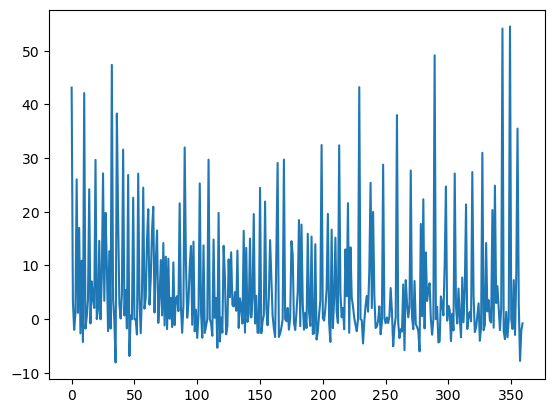

In [98]:
plt.plot(test_intensity)

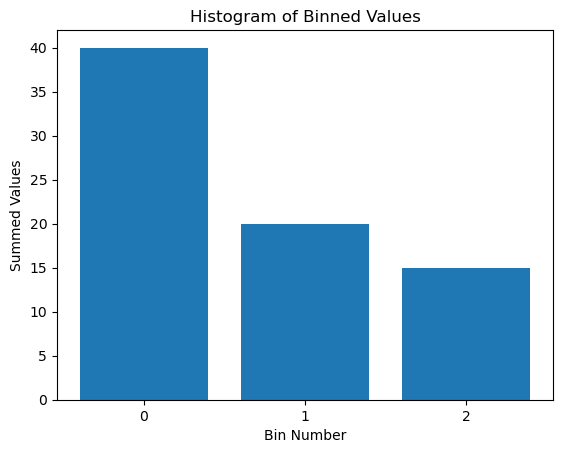

In [9]:
# Sample data: Replace these with your actual list1 and list2
list1 = alpha_angles
list2 = [10, 20, 5, 15, 25, 30]  # Values corresponding to each bin

# Number of bins (maximum bin number + 1, if bins start from 0)
num_bins = max(list1) + 1

# Initialize an array to store the sum of values for each bin
binned_values = np.zeros(num_bins)

# Aggregate values into bins
for bin_num, value in zip(list1, list2):
    binned_values[bin_num] += value

# Create the histogram (bar chart)
plt.bar(range(num_bins), binned_values)
plt.xlabel('Bin Number')
plt.ylabel('Summed Values')
plt.title('Histogram of Binned Values')
plt.xticks(range(num_bins))  # Ensure the bin numbers are shown correctly on x-axis
plt.show()

## Next step

### From ctapipe intensity_fitter.py

In [ ]:
# center_x: float
#     center of muon ring in the telescope frame
# pixel_x: quantity[angle]
#     Pixel x coordinate in telescope frame



dx = pixel_x_rad - center_x_rad
dy = pixel_y_rad - center_y_rad
ang = np.arctan2(dy, dx)

## Final version

In [9]:
filename = '/Users/vdk//muons2024/data/for_comparison/nsb_tuning/triple_tuning/run101_muon.simtel.gz'
source = EventSource(filename, max_events = 50)
event_iterator = iter(source)
event = next(event_iterator)
image_processor = ImageProcessor(source.subarray)
muon_processor = MuonProcessor(source.subarray)
calib = CameraCalibrator(image_extractor_type="GlobalPeakWindowSum",subarray = source.subarray)
calib(event)
image_processor(event)
muon_processor(event)

tel_description = source.subarray.tels[1]
geom = tel_description.camera.geometry
equivalent_focal_length = tel_description.optics.equivalent_focal_length
x_coord, y_coord = pixel_coords_to_telescope(geom, equivalent_focal_length)

TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types


### Functions to extract azimuthal angles and bin the intensity to this angles

In [10]:
def find_alpha_angles(x, y, x_center, y_center):
    """
    It should return the array with 1855 elements, each element contain angle with respect to the muon ring
    """
    # Calculate the angle with respect to the center of muon ring
    alpha_angles = np.rad2deg(np.arctan2(y - y_center, x - x_center))
    alpha_angles = np.round(alpha_angles).astype(int)
    alpha_angles[alpha_angles < 0] += 360
    return np.array(alpha_angles)

def intensity_binning(x, y, x_center, y_center, image, clean_mask):
    """
    It should return the array with 360 elements, each element contain number of p.e. in the bin width 1 deg with respect to muon center
    """
    # Its a list with angles, where to each x,y element of pixel 
    # we map the angle with respect to this particular muon ring. 
    # Each element is rounded to integer, to serve as a bin.
    alpha_angles = find_alpha_angles(x, y, x_center, y_center)
    intensity_azimuth = np.zeros(360)
    image[~clean_mask] = 0
    np.add.at(intensity_azimuth, alpha_angles, image)
    return intensity_azimuth


In [11]:
alpha_angles = find_alpha_angles(x_coord.degree, y_coord.degree, 0, 0)
image = event.dl1.tel[1].image

# Ensure the shapes match
if alpha_angles.shape != image.shape:
    raise ValueError(f"Shape mismatch: alpha_angles shape {alpha_angles.shape} and image shape {image.shape}")

test_intensity = intensity_binning(x_coord.degree, y_coord.degree, 0.0639, 0.39, image, event.dl1.tel[1].image_mask)


In [12]:
center_x = event.muon.tel[1].ring.center_fov_lon.to_value()
center_y = event.muon.tel[1].ring.center_fov_lat.to_value()
intensity_profile_temp = intensity_binning(x_coord.degree, y_coord.degree, center_x, center_y, event.dl1.tel[1].image, event.dl1.tel[1].image_mask)

In [6]:
filename = '/Users/vdk//muons2024/data/for_comparison/nsb_tuning/triple_tuning/run101_muon.simtel.gz'
source = EventSource(filename, max_events = 100)
event_iterator = iter(source)
image_processor = ImageProcessor(source.subarray)
muon_processor = MuonProcessor(source.subarray)
calib = CameraCalibrator(image_extractor_type="GlobalPeakWindowSum",subarray = source.subarray)

intensity_profiles = []

for event in event_iterator:
        calib(event)
        image_processor(event)
        muon_processor(event)
        
        center_x = event.muon.tel[1].ring.center_fov_lon.to_value()
        center_y = event.muon.tel[1].ring.center_fov_lat.to_value()
        #if event.muon.tel[1].parameters.completeness > 0.99:
        if event.muon.tel[1].efficiency.impact.to_value() > 8:
                intensity_profile_temp = intensity_binning(x_coord.degree, y_coord.degree, center_x, center_y, event.dl1.tel[1].image, event.dl1.tel[1].image_mask)
        
                intensity_profiles.append(intensity_profile_temp)

intensity_profiles = np.array(intensity_profiles)
        

TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types


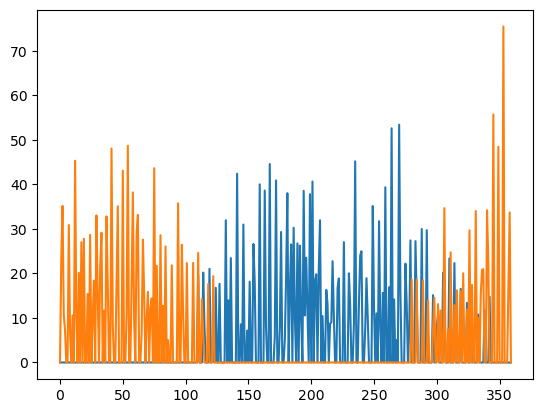

In [7]:
for shape in intensity_profiles:
    #plt.scatter(x_values,shape)
    plt.plot(shape,alpha=1)

    #plt.ylim(0,100)

In [161]:
event.muon.tel[1].parameters.completeness

nan

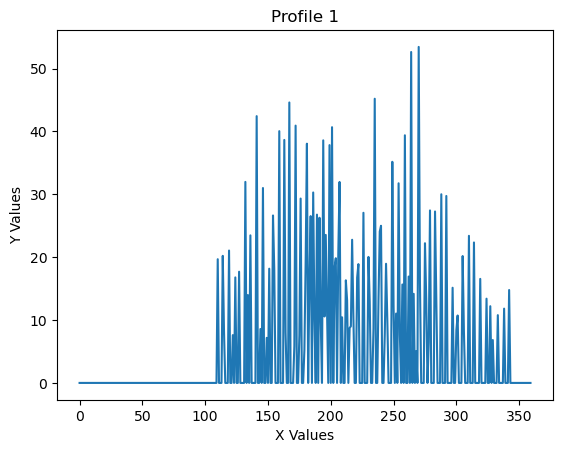

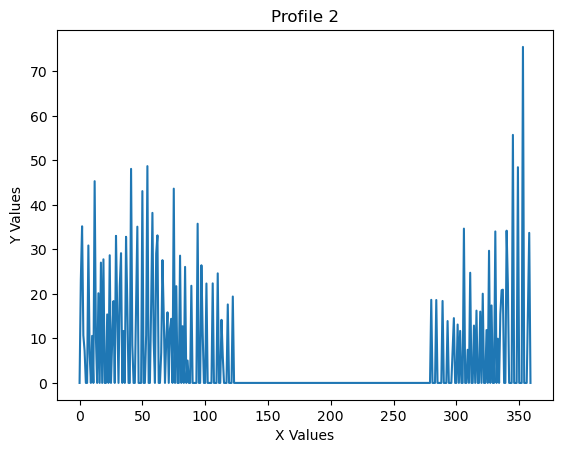

In [196]:
import matplotlib.pyplot as plt

# Assuming intensity_profiles is a list of 10 lists, each representing a profile
for i, shape in enumerate(intensity_profiles):
    plt.figure()  # Create a new figure for each profile
    plt.plot(shape, alpha=1)  # Plot the profile
    plt.title(f'Profile {i+1}')  # Add a title to each plot
    plt.xlabel('X Values')  # Label for the x-axis (optional)
    plt.ylabel('Y Values')  # Label for the y-axis (optional)
    plt.show()  # Show the plot

<Quantity 1.05226791 deg>

In [189]:
event.muon.tel[1].efficiency.impact

<Quantity 4.81038566 m>

## Revised version

In [26]:
def find_alpha_angles(x, y, x_center, y_center, x_cam, y_cam):
    # Calculate the azimuthal angles relative to the ring center
    alpha_angles = np.rad2deg(np.arctan2(y - y_center, x - x_center))
    alpha_angles[alpha_angles < 0] += 360

    # Calculate the reference angle from the ring center to the camera center
    phi0 = np.rad2deg(np.arctan2(y_center - y_cam, x_center - x_cam))
    if phi0 < 0:
        phi0 += 360

    # Adjust angles to have a common zero pointing towards the camera center
    alpha_angles_adjusted = alpha_angles - phi0
    alpha_angles_adjusted[alpha_angles_adjusted < 0] += 360
    return alpha_angles_adjusted

def intensity_binning(x, y, x_center, y_center, image, clean_mask, bin_size=10, x_cam=0, y_cam = 0):
    alpha_angles = find_alpha_angles(x, y, x_center, y_center, x_cam, y_cam)
    num_bins = int(360 / bin_size)
    intensity_azimuth = np.zeros(num_bins)
    image[~clean_mask] = 0

    # Map adjusted angles to bins
    bin_indices = (alpha_angles // bin_size).astype(int) % num_bins
    np.add.at(intensity_azimuth, bin_indices, image)
    return intensity_azimuth

In [41]:
filename = '/Users/vdk//muons2024/data/for_comparison/nsb_tuning/triple_tuning/run101_muon.simtel.gz'
source = EventSource(filename, max_events = 1000)
event_iterator = iter(source)
image_processor = ImageProcessor(source.subarray)
muon_processor = MuonProcessor(source.subarray)
calib = CameraCalibrator(image_extractor_type="GlobalPeakWindowSum",subarray = source.subarray)

intensity_profiles = []

for event in event_iterator:
        calib(event)
        image_processor(event)
        muon_processor(event)
        
        center_x = event.muon.tel[1].ring.center_fov_lon.to_value()
        center_y = event.muon.tel[1].ring.center_fov_lat.to_value()
        if event.muon.tel[1].parameters.completeness > 0.9:
        #if event.muon.tel[1].efficiency.impact.to_value() < 3:
                intensity_profile_temp = intensity_binning(
                        x_coord.degree, 
                        y_coord.degree, 
                        center_x, 
                        center_y, 
                        event.dl1.tel[1].image, 
                        event.dl1.tel[1].image_mask
                )
        
                intensity_profiles.append(intensity_profile_temp)
        if len(intensity_profiles) == 10:
            break

intensity_profiles = np.array(intensity_profiles)
        

TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types


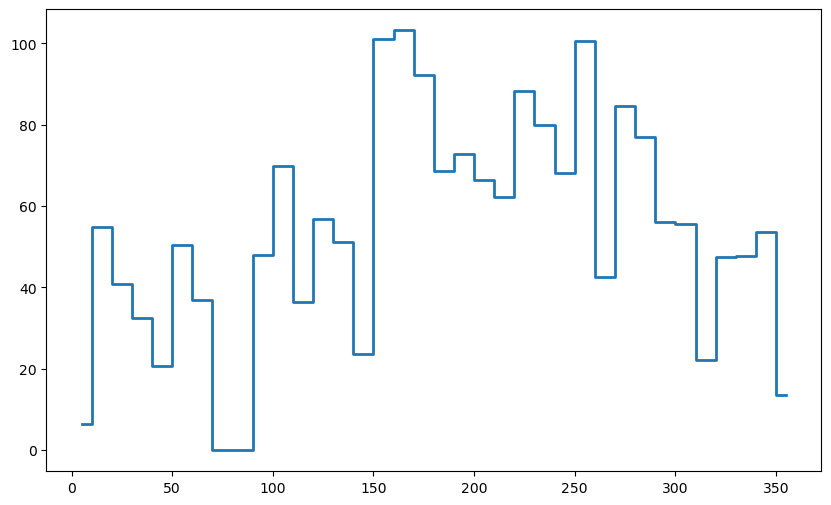

In [44]:
bin_size = 10  # You can adjust this to 5, 10, etc.
num_bins = int(360 / bin_size)
bin_edges = np.linspace(0, 360, num_bins + 1)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
plt.figure(figsize=(10, 6))

for shape in intensity_profiles[1:2]:
    #plt.scatter(x_values,shape)
    #plt.plot(shape,alpha=1)    
    plt.step(bin_centers, shape, where='mid', linewidth=2)

    #plt.ylim(0,100)

In [33]:
intensity_profiles.shape

(0,)

### Data

In [53]:
image_folder = glob.glob('/Users/vdk/muons2024/data/17043/dl1_image/*')
mask_folder = glob.glob('/Users/vdk/muons2024/data/17043/dl1_mask/*')
peak_folder = glob.glob('/Users/vdk/muons2024/data/17043/dl1_peak/*')

data_dl1_images = []
data_dl1_mask = []
data_dl1_peak = []

for file in image_folder:
    tmp_result = np.load(file)
    data_dl1_images.append(tmp_result)

for file in mask_folder:
    tmp_result = np.load(file)
    data_dl1_mask.append(tmp_result)

for file in peak_folder:
    tmp_result = np.load(file)
    data_dl1_peak.append(tmp_result)

In [66]:
file_path = '/Users/vdk/muons2024/data/dl1_LST-1.Run17043.0001.h5'

# Open the .h5 file
with h5py.File(file_path, 'r') as f:
    # Access the dataset
    dataset = f['dl1/event/telescope/image/LST_LSTCam']
    print(f"dataset {dataset}")
    print(f"dataset type {type(dataset)}")
    # Read the data
    data = dataset[:]
    print(f"data {data}")
    print(f"data type {type(data)}")
    
    # Print some information about the data
    # print(f'Dataset shape: {dataset.shape}')
    # print(f'Dataset dtype: {dataset.dtype}')
    # print('Data:', data)

    # If you want to read a specific part of the data, you can use slicing
    # For example, to read the first 10 entries:
    partial_data = dataset[:10]
#    print('First 10 entries:', partial_data)

dataset <HDF5 dataset "LST_LSTCam": shape (60032,), type "|V18575">
dataset type <class 'h5py._hl.dataset.Dataset'>
data [(17043,  60033, [ 2.18479490e+00,  7.41895533e+00,  4.45301199e+00,  3.48711538e+00,  3.73412848e+00,  3.83876383e-01,  5.20034933e+00,  4.59053659e+00,  4.82273960e+00,  2.44859743e+00,  4.26189947e+00,  3.61445737e+00,  2.68217182e+00,  1.35025537e+00,  5.61456299e+00,  3.10714769e+00,  4.87775373e+00,  4.09722519e+00,  4.90294743e+00,  4.15404272e+00,  4.52539921e+00,  7.70801115e+00,  5.42060137e+00,  5.53106260e+00,  1.48647165e+00,  4.92116690e+00,  4.67550135e+00,  4.56112480e+00,  2.78146577e+00,  1.31329620e+00,  1.27662003e+00,  3.96690369e+00,  1.58363175e+00,  3.47593641e+00,  1.27852273e+00,  3.81611371e+00,  6.66814232e+00,  6.13256311e+00,  4.08009958e+00,  7.08085728e+00,  3.28616953e+00,  2.09325838e+00,  1.70617962e+00,  4.45773840e+00,  5.13461828e+00,  5.20707369e+00,  3.57422233e+00,  3.88721418e+00,  5.12870741e+00,  7.03164768e+00,  2.70752335